<h1 style="text-align: center; font-weight: bold;">
Model LSTM for Time Series Forecasting Temperature
</h1>


# LLibreries

In [1]:
# üì¶ Gesti√≥ b√†sica de dades i formats
import os
import json
import random
import warnings
from datetime import datetime
from itertools import combinations

# üìä Tractament i visualitzaci√≥ de dades
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import plotly.express as px

# Configuraci√≥ visuals
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore")  # Ignorar warnings per evitar soroll

# üìà Barra de progr√©s
from tqdm.notebook import tqdm

# üß™ Preprocessament i m√®triques
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error)

# ü§ñ TensorFlow i Keras ‚Äî Xarxes LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, LSTM
from keras import Model



2025-06-12 08:51:46.084633: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 08:51:46.107422: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Importaci√≥ de Dades

## Importaci√≥ i reformateig des de JSON 

No cal fer-ho es pot llegir directament des del CSV ja preprocessat


La seg√ºent cel¬∑la √©s per llegir des del CSV

In [ ]:
# Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Data/Dades_T_estacions_xema_Z1'
fitxer_dades = 'SCM_T_Z1.json'

path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades)

# Obrir un arxiu json per veure com esta estructurat i com organitzar les dades
with open(path_dades, 'r') as f:
    data = json.load(f)

# Accedemos a las lecturas (temperaturas) del JSON
lecturas = data[0]['variables'][0]['lectures']

# Convertimos las lecturas a un DataFrame con solo las columnas necesarias
df = pd.DataFrame(lecturas)[['data', 'valor']]


# Convertimos la columna 'data' a tipo datetime para an√°lisis posterior
df['data'] = pd.to_datetime(df['data'], utc=True)

df = df.sort_values(by='data')

# Eliminem les dades que estan entre hores, es a dir en minuts que no son 0
df = df[df['data'].dt.minute == 0]

# Restablir l'index
df = df.reset_index(drop=True)

df

## Importaci√≥ de dades dades des de CSV

Dades Carregades des del fitxer CSV netejat i guardat pel fitxer de data preprocessing

In [2]:
#Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Data/Dades_T_estacions_xema_Z1'
fitxer_dades_csv = 'SCM_T_Z1.csv'

path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades_csv)

# Llegir el fitxer CSV i importar les dades

df = pd.read_csv(path_dades)

# Convertir la columna 'data' a tipus datetime
df['data'] = pd.to_datetime(df['data'], utc=True)

df

data  valor
0      1998-01-01 00:00:00+00:00  -4.60
1      1998-01-01 01:00:00+00:00  -5.10
2      1998-01-01 02:00:00+00:00  -5.30
3      1998-01-01 03:00:00+00:00  -5.50
4      1998-01-01 04:00:00+00:00  -5.80
...                          ...    ...
230024 2024-12-31 19:00:00+00:00   0.10
230025 2024-12-31 20:00:00+00:00  -0.60
230026 2024-12-31 21:00:00+00:00  -0.60
230027 2024-12-31 22:00:00+00:00  -0.70
230028 2024-12-31 23:00:00+00:00  -0.80

[230029 rows x 2 columns]

In [3]:
# seleccionem les dades LSTM, del 2020 en endavant ja que a partir d'aleshores no tenen cap interrupci√≥
df_lstm = df[df['data'] >= '2020-01-01'].copy()

# Restablir l'index
df_lstm = df_lstm.reset_index(drop=True)

df_lstm

data  valor
0     2020-01-01 00:00:00+00:00   1.30
1     2020-01-01 01:00:00+00:00   1.60
2     2020-01-01 02:00:00+00:00   3.20
3     2020-01-01 03:00:00+00:00   4.40
4     2020-01-01 04:00:00+00:00   4.00
...                         ...    ...
43843 2024-12-31 19:00:00+00:00   0.10
43844 2024-12-31 20:00:00+00:00  -0.60
43845 2024-12-31 21:00:00+00:00  -0.60
43846 2024-12-31 22:00:00+00:00  -0.70
43847 2024-12-31 23:00:00+00:00  -0.80

[43848 rows x 2 columns]

## Visualitzaci√≥ Pr√®via de les dades

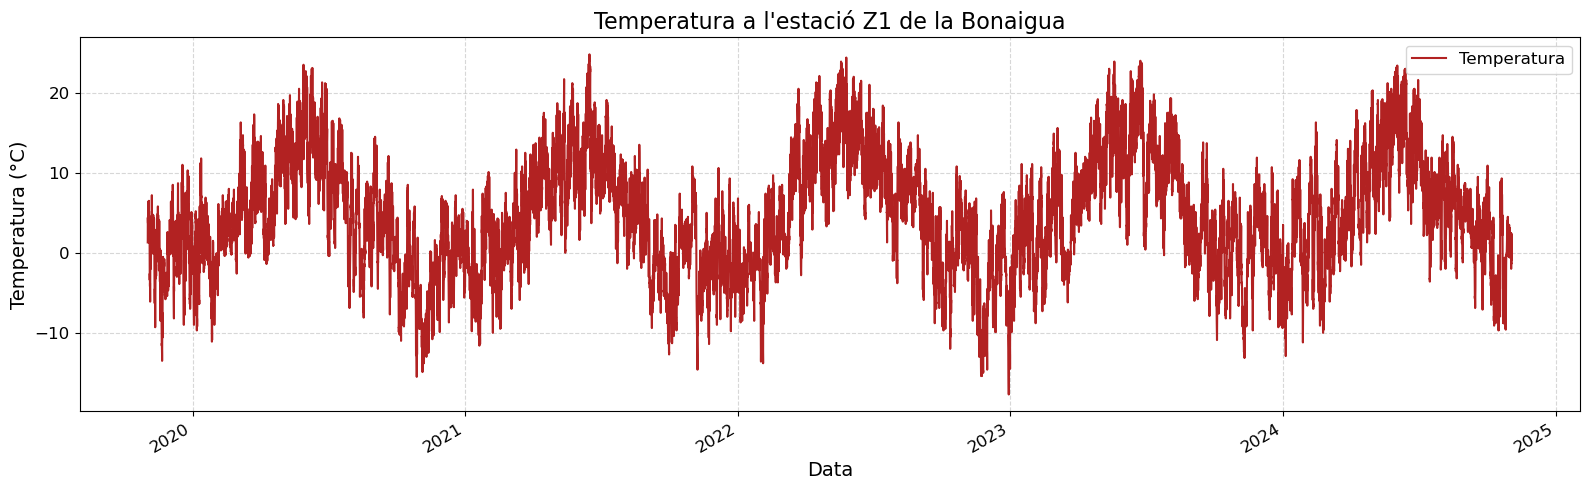

In [4]:
plt.figure(figsize=(16, 5))
plt.plot(df_lstm['data'], df_lstm['valor'], label='Temperatura', color='firebrick', linewidth=1.5)

# Millores visuals
plt.title('Temperatura a l\'estaci√≥ Z1 de la Bonaigua', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (¬∞C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Format de dates a l‚Äôeix X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Separaci√≥ de les dades en entrenament, validaci√≥ i test

In [5]:
# Definim les dates l√≠mit per la separaci√≥
data_max = df_lstm['data'].max()

data_limit_train = data_max - pd.DateOffset(months=6)      # L√≠mit final del train
data_limit_val = data_max - pd.DateOffset(months=3)        # L√≠mit final de la validaci√≥

# Separem els datasets
df_train = df_lstm[df_lstm['data'] <= data_limit_train].copy().reset_index(drop=True)
df_val = df_lstm[(df_lstm['data'] > data_limit_train) & (df_lstm['data'] <= data_limit_val)].copy().reset_index(drop=True)
df_test = df_lstm[df_lstm['data'] > data_limit_val].copy().reset_index(drop=True)


## Visualitzaci√≥ dels conjunts de dades

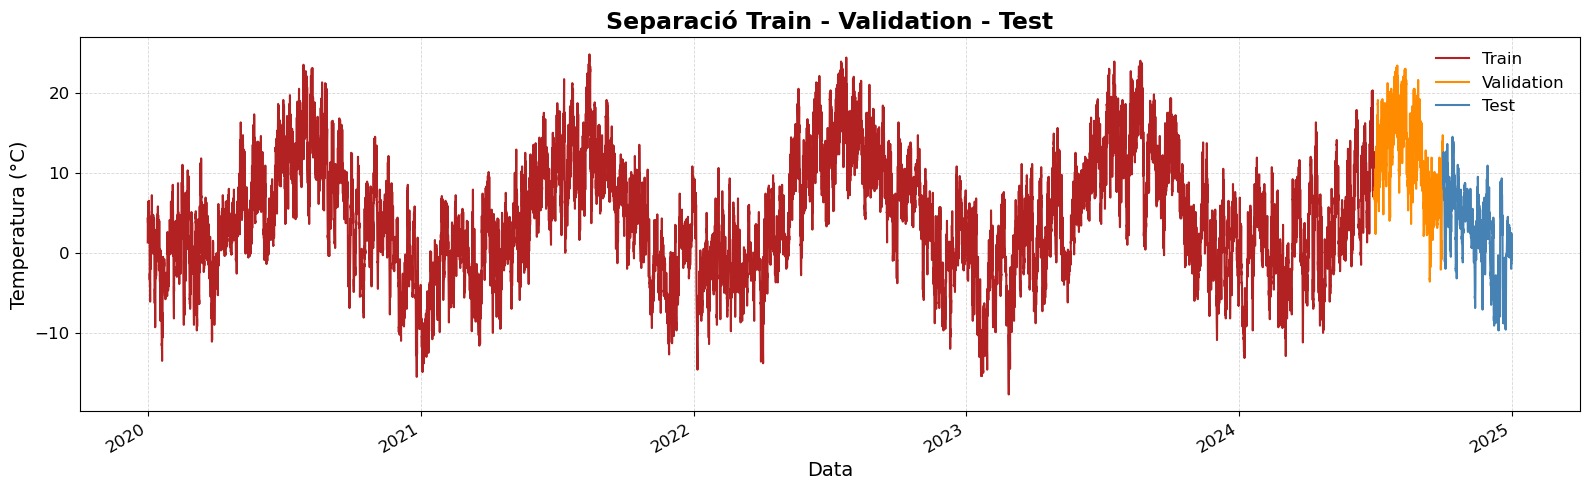

In [6]:

# Confirmem la separaci√≥ amb un gr√†fic
plt.figure(figsize=(16, 5))
plt.plot(df_train['data'], df_train['valor'], label='Train', color='firebrick', linewidth=1.5)
plt.plot(df_val['data'], df_val['valor'], label='Validation', color='darkorange', linewidth=1.5)
plt.plot(df_test['data'], df_test['valor'], label='Test', color='steelblue', linewidth=1.5)

plt.title('Separaci√≥ Train - Validation - Test', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (¬∞C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


# Definic√≥ de Funcions

In [ ]:
# Funci√≥ per escalar les dades a milers

def escala_mil(x, pos):
    """
    Funci√≥ per formatar els ticks de l‚Äôeix Y multiplicant per 1000.
    √âs √∫til quan vols mostrar valors petits (com MSE en [0, 0.01]) en una escala m√©s llegible.

    Args:
        x (float): valor del tick original (per exemple, 0.0013).
        pos (int): posici√≥ del tick en l‚Äôeix (0, 1, 2...). No s‚Äôutilitza aqu√≠, per√≤ √©s necessari
                   perqu√® FuncFormatter sempre crida la funci√≥ amb dos arguments.

    Returns:
        str: valor formatat com a string, multiplicat per 1000 i amb 1 decimal (ex: '1.3').
    """
    val = x * 1000
    return f'{val:.1f}'



# Creem una funci√≥ per crear sequences per LSTM d'entrada

def create_sequences(series, window_size, n_outputs=1, n_slide=1):
    """
    Crea seq√º√®ncies d'entrada i sortida per predicci√≥ simple o multi-output, 
    amb control del pas de despla√ßament entre finestres.

    Args:
        series (array): s√®rie temporal escalada.
        window_size (int): llargada de la finestra d'entrada.
        n_outputs (int): nombre de passos a predir (per defecte 1).
        n_slide (int): quant avancem la finestra a cada iteraci√≥ (per defecte 1).

    LSTM espera una entrada en 3 dimensions:
    (n_samples, window_size, n_features)
        On:
    - n_samples = nombre de finestres que hem generat
    - window_size = longitud de cada finestra (n√∫mero de valors consecutius)
    - n_features = nombre de variables per timestep (en aquest cas, 1 sola: la temperatura)

    Returns:
        X (np.array): seq√º√®ncies d'entrada, forma (samples, window_size, 1).
        y (np.array): seq√º√®ncies de sortida, forma (samples, n_outputs) si n_outputs > 1, 
                      o (samples, 1) si n_outputs = 1.
    """
    X, y = [], []
    i = window_size
    while i <= len(series) - n_outputs:
        X.append(series[i - window_size:i])
        if n_outputs == 1:
            y.append(series[i])
        else:
            y.append(series[i:i + n_outputs])
        i += n_slide
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y)
    if n_outputs == 1:
        y = y.reshape(-1, 1)  # Ara fa el reshape que Keras espera per a regressi√≥ 1D
    return X, y


 üìä Estrat√®gies de predicci√≥ implementades


En aquest projecte s'han implementat tres estrat√®gies de predicci√≥ basades en xarxes LSTM per tal d'avaluar diferents aproximacions a la predicci√≥ seq√ºencial de temperatura:

---

üü© 1. `prediccio_batch(...)` ‚Äî Predicci√≥ directa per lots

Aquesta estrat√®gia utilitza finestres fixes d'entrada (`X_test`) per fer prediccions independents de forma simult√†nia. Cada finestra genera una predicci√≥ d‚Äôun √∫nic pas i no dep√®n de les sortides anteriors.

**√ös t√≠pic:**
```python
df_test_pred, y_pred = prediccio_batch(model, X_test, df_test_pred, scaler, nom_columna='pred_batch')
```

---

üîÅ 2. `prediccio_multi_step_iterativa(...)` ‚Äî Predicci√≥ iterativa encadenada

Predicci√≥ pas a pas: la sortida del model en cada pas es reinjecta com a entrada per predir el seg√ºent valor. Aquesta estrat√®gia simula el funcionament d‚Äôun sistema en temps real, per√≤ pot acumular error amb el temps.

**√ös t√≠pic:**
```python
df_test_pred, y_pred_iter = prediccio_multi_step_iterativa(model, X_test, df_test_pred, scaler, nom_columna='pred_iter')
```

---

üîÑ 3. `prediccio_iterativa_reinjection(...)` ‚Äî Predicci√≥ iterativa amb reinjecci√≥ de dades reals

Similars a l'estrat√®gia iterativa, per√≤ cada `k` passos es reinjecta el valor real del conjunt de test. Aix√≤ ajuda a estabilitzar les prediccions i reduir l‚Äôacumulaci√≥ d‚Äôerror.

**√ös t√≠pic:**
```python
df_test_pred, y_pred_reinject = prediccio_iterativa_reinjection(model, X_test, df_test_pred, scaler, reinjeccio=5, nom_columna='pred_reinject')
```

---

Totes les funcions modifiquen directament el `df_test_pred` afegint una columna amb les prediccions desescalades, i retornen tamb√© l‚Äôarray de prediccions per facilitar l‚Äôan√†lisi posterior (m√®triques, gr√†fics, etc.).
```


In [236]:
def prediccio_batch(model, X_test, df_test_pred, scaler, nom_columna='pred_batch'):
    """
    Fa una predicci√≥ batch (totes les finestres alhora), desescala les prediccions i les afegeix directament a df_test_pred.

    Args:
        model: model LSTM entrenat.
        X_test (np.array): finestres d‚Äôentrada per a la predicci√≥ (forma: (n_samples, window_size, 1)).
        df_test_pred (pd.DataFrame): DataFrame amb la columna 'valor' desescalada. Es modifica in-place.
        scaler: MinMaxScaler ajustat sobre les dades de train.
        nom_columna (str): nom de la columna on s‚Äôenganxaran les prediccions (per defecte 'pred_batch').

    Returns:
        df_test_pred (DataFrame): DataFrame amb la nova columna de predicci√≥.
        y_pred_rescaled (np.array): prediccions desescalades (forma: (n_samples,)).
    """
    # Predicci√≥ i desescalat
    y_pred = model.predict(X_test, verbose=0)
    y_pred_rescaled = scaler.inverse_transform(y_pred).flatten()

    # Assignar al DataFrame (ignorant les primeres files sense prou context)
    window_size = X_test.shape[1]
    idx_valid = df_test_pred.index[window_size:]
    df_test_pred.loc[idx_valid, nom_columna] = y_pred_rescaled

    return df_test_pred




def prediccio_multi_step_iterativa(model, X_test, df_test_pred, scaler, nom_columna='pred_iter'):
    """
    Fa una predicci√≥ multi-step iterativa, reinjectant cada predicci√≥ com a nou input,
    i afegeix les prediccions desescalades directament a df_test_pred.

    Args:
        model: model LSTM entrenat.
        X_test (np.array): finestres d‚Äôentrada (forma: (n_samples, window_size, 1)).
        df_test_pred (pd.DataFrame): DataFrame amb la columna 'valor' desescalada. Es modifica in-place.
        scaler: MinMaxScaler ajustat sobre les dades de train.
        nom_columna (str): nom de la columna on s‚Äôenganxaran les prediccions (per defecte 'pred_iter').

    Returns:
        df_test_pred (DataFrame): amb la nova columna de predicci√≥ iterativa afegida.
        y_pred_rescaled (np.array): prediccions desescalades (forma: (n_samples,)).
    """
    window_size = X_test.shape[1]
    n_passos = X_test.shape[0]

    seq = X_test[0].copy()  # Seq√º√®ncia inicial escalada (window_size, 1)
    preds_scaled = []

    for _ in range(n_passos):
        input_seq = seq.reshape((1, window_size, 1))
        pred_scaled = model.predict(input_seq, verbose=0)[0, 0]
        preds_scaled.append(pred_scaled)
        seq = np.append(seq[1:], [[pred_scaled]], axis=0)

    # Desescalar les prediccions
    y_pred_rescaled = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()

    # Assignar les prediccions desescalades al final del DataFrame
    idx_valid = df_test_pred.index[window_size:window_size + n_passos]
    df_test_pred.loc[idx_valid, nom_columna] = y_pred_rescaled

    return df_test_pred

def prediccio_iterativa_reinjection(model, X_test, df_test_pred, scaler, reinjeccio=5, nom_columna='pred_reinject'):
    """
    Fa una predicci√≥ iterativa amb reinjecci√≥ de valors reals cada 'reinjeccio' passos,
    i afegeix les prediccions desescalades al df_test_pred.

    Args:
        model: model LSTM entrenat.
        X_test (np.array): finestres d‚Äôentrada (forma: (n_samples, window_size, 1)).
        df_test_pred (pd.DataFrame): DataFrame amb la columna 'valor_scaled'. Es modifica in-place.
        scaler: MinMaxScaler ajustat sobre les dades de train.
        reinjeccio (int): nombre de passos entre reinjeccions de dades reals.
        nom_columna (str): nom de la columna on s‚Äôenganxaran les prediccions.

    Returns:
        df_test_pred (DataFrame): amb la nova columna de prediccions afegida.
        y_pred_rescaled (np.array): prediccions desescalades (forma: (n_samples,)).
    """
    window_size = X_test.shape[1]
    n_passos = X_test.shape[0]

    seq = X_test[0].copy()  # Seq√º√®ncia inicial (forma: (window_size, 1))
    preds_scaled = []
    valors_scaled = df_test_pred['valor_scaled'].values

    for i in range(n_passos):
        input_seq = seq.reshape((1, window_size, 1))
        pred_scaled = model.predict(input_seq, verbose=0)[0, 0]
        preds_scaled.append(pred_scaled)

        if (i + 1) % reinjeccio == 0:
            start_real = window_size + i + 1 - reinjeccio
            end_real = start_real + window_size
            if end_real <= len(valors_scaled):
                seq = valors_scaled[start_real:end_real].reshape(-1, 1).copy()
            else:
                seq = np.append(seq[1:], [[pred_scaled]], axis=0)
        else:
            seq = np.append(seq[1:], [[pred_scaled]], axis=0)

    y_pred_rescaled = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
    # idx_valid = df_test_pred.index[window_size:window_size + n_passos]
    idx_valid = df_test_pred.iloc[window_size : window_size + n_passos].index

    df_test_pred.loc[idx_valid, nom_columna] = y_pred_rescaled

    return df_test_pred


# Preparaci√≥ de les dades per a l'entrenament del model (escalaci√≥)

In [90]:
# Escalem la data

scaler = MinMaxScaler()

# Escalar nom√©s sobre train i transformar val i test
df_train['valor_scaled'] = scaler.fit_transform(df_train[['valor']])
df_val['valor_scaled'] = scaler.transform(df_val[['valor']])
df_test['valor_scaled'] = scaler.transform(df_test[['valor']])


# Observem com queden les dades
print('Train dataset shape:', df_train.shape)
display(df_train.head())

print('Validation dataset shape:', df_val.shape)
display(df_val.head())

print('Test dataset shape:', df_test.shape)
display(df_test.head())

Train dataset shape: (39432, 3)


data  valor  valor_scaled
0 2020-01-01 00:00:00+00:00   1.30          0.45
1 2020-01-01 01:00:00+00:00   1.60          0.45
2 2020-01-01 02:00:00+00:00   3.20          0.49
3 2020-01-01 03:00:00+00:00   4.40          0.52
4 2020-01-01 04:00:00+00:00   4.00          0.51

Validation dataset shape: (2208, 3)


data  valor  valor_scaled
0 2024-07-01 00:00:00+00:00   7.60          0.60
1 2024-07-01 01:00:00+00:00   6.80          0.58
2 2024-07-01 02:00:00+00:00   6.90          0.58
3 2024-07-01 03:00:00+00:00   6.90          0.58
4 2024-07-01 04:00:00+00:00   7.10          0.58

Test dataset shape: (2208, 3)


data  valor  valor_scaled
0 2024-10-01 00:00:00+00:00   8.60          0.62
1 2024-10-01 01:00:00+00:00   9.70          0.64
2 2024-10-01 02:00:00+00:00  10.20          0.66
3 2024-10-01 03:00:00+00:00  10.50          0.66
4 2024-10-01 04:00:00+00:00  10.40          0.66

# Model LSTM step by step 1 predicci√≥

## Preparaci√≥ de les seq√º√®ncies per a l'entrenament

In [217]:
# Parametres Globals del model LSTM

# Parametritzaci√≥ per a la creaci√≥ de seq√º√®ncies multi-step 
WINDOW_SIZE = 24  # provar m√©s tard 48, 72, 168...
N_OUTPUTS = 1  # Per predicci√≥ simple, si fos multi-step seria > 1
N_SLIDE = 1  # Despla√ßament de la finestra, 1 per predicci√≥ simple
N_FEATURES = 1  # Nom√©s una variable: temperatura

In [218]:
# Creem una copia del df_test per evitar canviar el df original i afegim les dades escalades i les posteriors prediccions
df_test_pred = df_test.copy()

# Creem les sequences per LSTM d'entrada i sortida tant per train com per test
# X_train, X_val i X_test seran les dades d'entrada, i y_train, y_val i y_test seran les etiquetes (valors a predir)

X_train, y_train = create_sequences(df_train['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_val, y_val = create_sequences(df_val['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_test, y_test = create_sequences(df_test_pred['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)

In [219]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (39408, 24, 1)
y_train shape: (39408, 1)


## Deficini√≥ del Model i entrenament


In [ ]:

# ============================
# Definim el model LSTM
# ============================

model = Sequential([
    # 1a capa LSTM amb 64 neurones (unitats)
    # - return_sequences=True perqu√® tenim m√©s capes LSTM despr√©s
    # - input_shape = (timesteps, features) ‚Üí cada seq√º√®ncia t√© X valors de temperatura (1 feature)
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, N_FEATURES)),

    # Dropout per reduir overfitting (desactiva aleat√≤riament un 20% de les neurones durant l'entrenament)
    Dropout(0.2),

    # 2a capa LSTM (encara retorna seq√º√®ncies per passar-les a la seg√ºent LSTM)
    LSTM(64, return_sequences=True),
    Dropout(0.2),

    # 3a capa LSTM (√∫ltima ‚Üí no retorna seq√º√®ncia, nom√©s la sortida final)
    LSTM(64),
    Dropout(0.2),

    # Capa de sortida Dense:
    # - 1 neurona perqu√® fem una predicci√≥ escalar (una sola temperatura)
    Dense(1)
])

# Compilaci√≥ del model:
# - Optimitzador Adam ‚Üí ajusta els pesos de forma eficient
# - Funci√≥ de p√®rdua MSE ‚Üí ideal per problemes de regressi√≥ com el nostre
model.compile(
    optimizer='adam',
    loss='mse'
)


# Callback EarlyStopping per aturar l'entrenament si no millora el val_loss
early_stop = EarlyStopping(
    monitor='val_loss',      # monitoritza la p√®rdua de validaci√≥
    patience=5,              # espera 5 epochs sense millora abans d'aturar
    restore_best_weights=True  # recupera els pesos del millor epoch
)


In [ ]:
# Estableix la llavor per a la reprodu√Øbilitat
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Entrenament del model:
# - epochs = 50 ‚Üí nombre d'iteracions sobre tot el dataset
# - batch_size = 32 ‚Üí nombre de mostres processades abans d'actualitzar els pesos
# - shuffle = False ‚Üí mantenim l'ordre de les dades per m√©s control

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32, # mida del lot per l'entrenament
    validation_data=(X_val, y_val),  # validaci√≥ amb dades de validaci√≥ separades
    callbacks=[early_stop],
    verbose=1,
    shuffle=False  # opcional, si vols control total de l'ordre
)

In [ ]:
# Graficar l'evoluci√≥ de la p√®rdua durant l'entrenament

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(history.history['loss'], label='P√®rdua Entrenament')
ax.plot(history.history['val_loss'], label='P√®rdua Validaci√≥')
ax.set_title("Evoluci√≥ de la p√®rdua durant l'entrenament")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE (√ó10‚Åª¬≥)")

# Per ticks x cada 2 epochs
ax.set_xticks(np.arange(0, len(history.history['loss']), 1))

# Format ticks y amb 1 decimal
ax.yaxis.set_major_formatter(FuncFormatter(escala_mil))

# For√ßa ticks a enters (per√≤ com fem decimals, pot ser opcional)
ax.yaxis.set_major_locator(MaxNLocator(integer=False, nbins=6))  # nbins controla nombre m√†xim ticks

ax.legend()
ax.grid(True)
plt.show()


In [18]:
# Creem el directori per guardar el model si no existeix
model_path = os.path.join(__path__, 'models', 'lstm_model.h5')
os.makedirs(os.path.dirname(model_path), exist_ok=True)  # Assegurem que el directori existeix


In [ ]:
# Guardem el model entrenat
# Guarda nom√©s l'arquitectura i els pesos, sense optimitzador ni funci√≥ de p√®rdua
model.save(model_path, include_optimizer=False)

In [220]:
# Carrega del model guardat
model = load_model(model_path)
print("Model carregat correctament des de:", model_path)
print(model.summary())

Model carregat correctament des de: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/models/lstm_model.h5


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm (LSTM)                     ‚îÇ (None, 24, 64)         ‚îÇ        16,896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 24, 64)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)                   ‚îÇ (None, 24, 64)         ‚îÇ        33,024 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 24, 64)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_2 (LSTM)                   ‚îÇ (None, 64)             ‚îÇ        33,024 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 1)              ‚îÇ            65 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 83,009 (324.25 KB)

 Trainable params: 83,009 (324.25 KB)

 Non-trainable params: 0 (0.00 B)

None


## Prediccions del model 

### Predicci√≥ batch

In [221]:
df_test_pred = prediccio_batch(model, X_test, df_test_pred, scaler, nom_columna='prediccio_batch')

In [222]:
# Avaluaci√≥ de les m√®triques

rmse_batch = np.sqrt(mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_batch'][WINDOW_SIZE:]))
mse_batch = mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_batch'][WINDOW_SIZE:])
mae_batch = mean_absolute_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_batch'][WINDOW_SIZE:])


print(f"üìä M√®triques predicci√≥ batch: ")
print(f"   ‚ñ∏ RMSE: {rmse_batch:.4f} ¬∞C")
print(f"   ‚ñ∏ MSE: {mse_batch:.4f} ¬∞C¬≤")
print(f"   ‚ñ∏ MAE: {mae_batch:.4f} ¬∞C")

üìä M√®triques predicci√≥ batch: 
   ‚ñ∏ RMSE: 0.8742 ¬∞C
   ‚ñ∏ MSE: 0.7642 ¬∞C¬≤
   ‚ñ∏ MAE: 0.6152 ¬∞C


### Predicci√≥ Multi-Step Iterativa

In [ ]:
df_test_pred = prediccio_multi_step_iterativa(model, X_test, df_test_pred, scaler, nom_columna='prediccio_iter')

In [179]:
# Avaluaci√≥ de les m√®triques

rmse_iter = np.sqrt(mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_iter'][WINDOW_SIZE:]))
mse_iter = mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_iter'][WINDOW_SIZE:])
mae_iter = mean_absolute_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_iter'][WINDOW_SIZE:])


print(f"üìä M√®triques predicci√≥ iterativa: ")
print(f"   ‚ñ∏ RMSE: {rmse_iter:.4f} ¬∞C")
print(f"   ‚ñ∏ MSE: {mse_iter:.4f} ¬∞C¬≤")
print(f"   ‚ñ∏ MAE: {mae_iter:.4f} ¬∞C")

üìä M√®triques predicci√≥ iterativa: 
   ‚ñ∏ RMSE: 10.9260 ¬∞C
   ‚ñ∏ MSE: 119.3783 ¬∞C¬≤
   ‚ñ∏ MAE: 9.7996 ¬∞C


### Predicci√≥ iterativa amb reinjecci√≥ de dades

In [237]:
df_test_pred = prediccio_iterativa_reinjection(model, X_test, df_test_pred, scaler, reinjeccio=5, nom_columna='prediccio_reinject')

In [238]:
# Avaluaci√≥ de les m√®triques

rmse_reinj = np.sqrt(mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_reinject'][WINDOW_SIZE:]))
mse_reinj = mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_reinject'][WINDOW_SIZE:])
mae_reinj = mean_absolute_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_reinject'][WINDOW_SIZE:])


print(f"üìä M√®triques predicci√≥ amb reinjecci√≥: ")
print(f"   ‚ñ∏ RMSE: {rmse_reinj:.4f} ¬∞C")
print(f"   ‚ñ∏ MSE: {mse_reinj:.4f} ¬∞C¬≤")
print(f"   ‚ñ∏ MAE: {mae_reinj:.4f} ¬∞C")

üìä M√®triques predicci√≥ amb reinjecci√≥: 
   ‚ñ∏ RMSE: 3.5818 ¬∞C
   ‚ñ∏ MSE: 12.8295 ¬∞C¬≤
   ‚ñ∏ MAE: 2.7137 ¬∞C


## M√®triques, errors i graficaci√≥ 

In [226]:
# Taula comparativa de m√®triques
m√®triques = pd.DataFrame({
    'M√®trica': ['RMSE', 'MSE', 'MAE'],
    'Predicci√≥ Batch': [rmse_batch, mse_batch, mae_batch],
    'Predicci√≥ Iterativa': [rmse_iter, mse_iter, mae_iter],
    'Predicci√≥ Reinjecci√≥': [rmse_reinj, mse_reinj, mae_reinj]
})
m√®triques.set_index('M√®trica', inplace=True)
m√®triques = m√®triques.round(4)  # Arrodonim a 4 decimals
m√®triques

Predicci√≥ Batch  Predicci√≥ Iterativa  Predicci√≥ Reinjecci√≥
M√®trica                                                            
RMSE                0.87                10.93                  3.58
MSE                 0.76               119.38                 12.83
MAE                 0.62                 9.80                  2.71

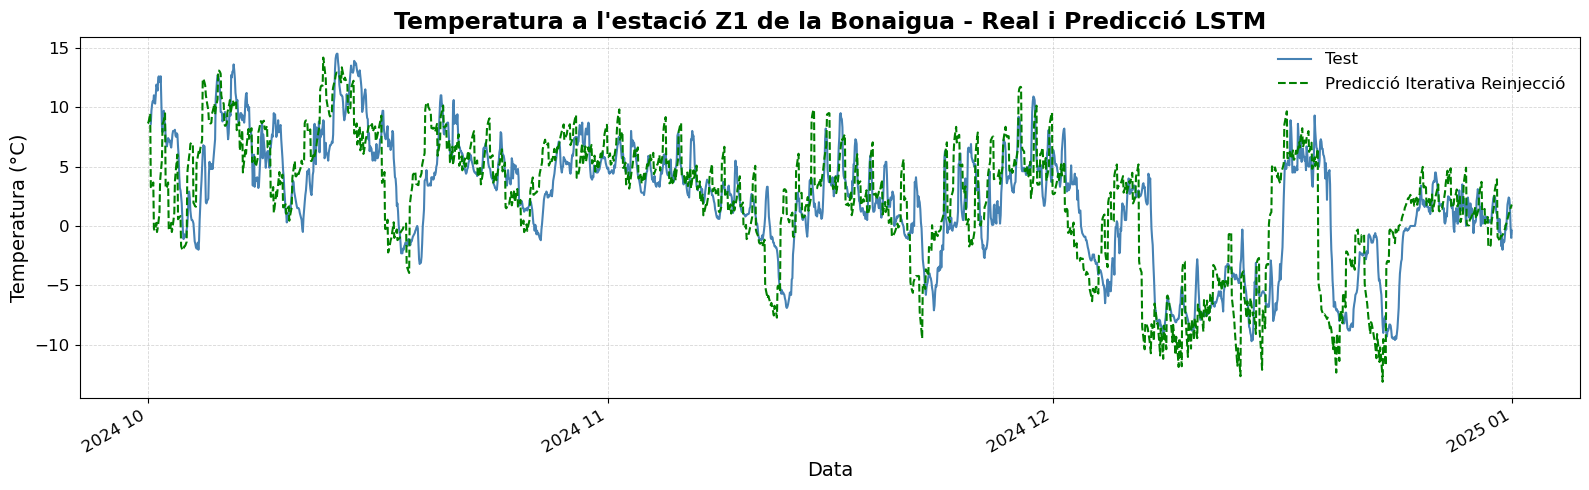

In [239]:
# Defineix quants dies enrere vols mostrar del train
dies_enrere = 30
data_limit = df_train['data'].max() - pd.Timedelta(days=dies_enrere)
df_train_filtrat = df_train[df_train['data'] >= data_limit]

plt.figure(figsize=(16, 5))

# √öltims dies del train
# plt.plot(df_train_filtrat['data'], df_train_filtrat['valor'], label='Train (√∫ltims 30 dies)', color='firebrick', linewidth=1.5)

# Validaci√≥ completa
# plt.plot(df_val['data'], df_val['valor'], label='Validation', color='darkgreen', linewidth=1.5)

# Test complet
plt.plot(df_test_pred['data'], df_test_pred['valor'].shift(5), label='Test', color='steelblue', linewidth=1.5)

# Predicci√≥ sobre test
# plt.plot(df_test_pred['data'], df_test_pred['prediccio_batch'], label='Predicci√≥ Batch', color='darkorange', linewidth=1.5, linestyle='--')

# Predicci√≥ iterativa
# plt.plot(df_test_pred['data'], df_test_pred['prediccio_iter'], label='Predicci√≥ Iterativa', color='purple', linewidth=1.5, linestyle='--')

# Predicci√≥ iterativa amb reinjecci√≥
# plt.plot(df_test_pred['data'], df_test_pred['prediccio_reinject'], label='Predicci√≥ Iterativa Reinjecci√≥', color='green', linewidth=1.5, linestyle='--')
plt.plot(df_test_pred['data'], df_test_pred['prediccio_reinject'], label='Predicci√≥ Iterativa Reinjecci√≥', color='green', linewidth=1.5, linestyle='--')

plt.title('Temperatura a l\'estaci√≥ Z1 de la Bonaigua - Real i Predicci√≥ LSTM', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (¬∞C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


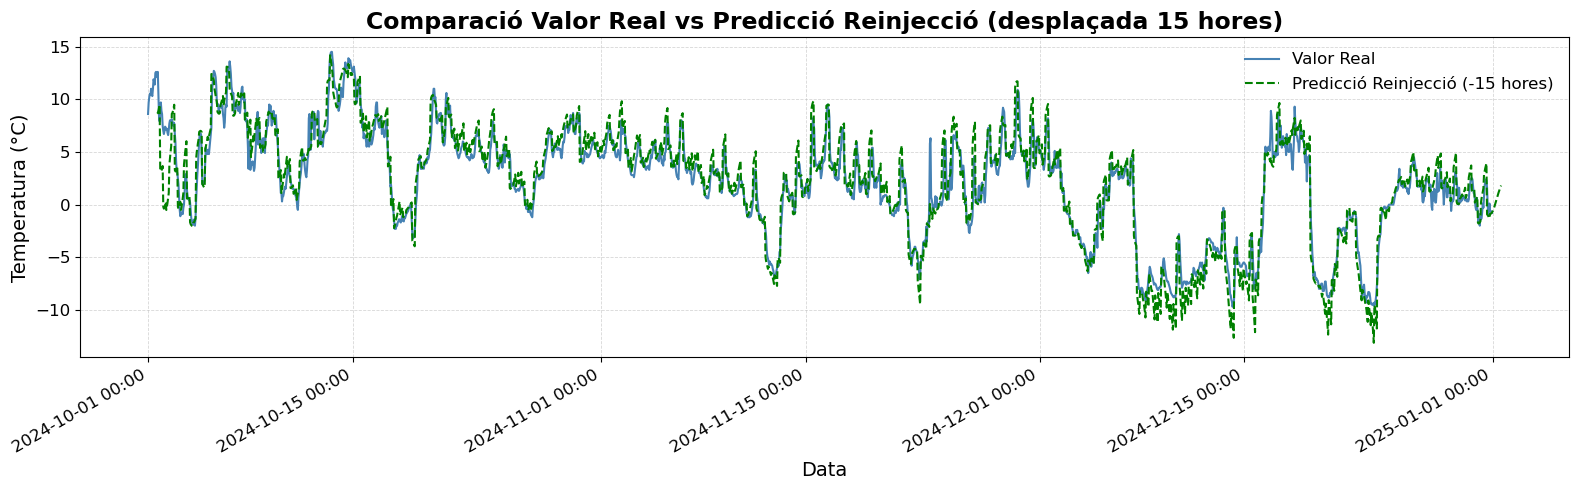

In [241]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Despla√ßament en hores
despla√ßament_hores = 15

# Crear dates despla√ßades
dates_shifted = df_test_pred['data'] + pd.Timedelta(hours=despla√ßament_hores)

# Valors
valors_reals = df_test_pred['valor']
valors_pred_reinject = df_test_pred['prediccio_reinject']

# Dibuix del gr√†fic
plt.figure(figsize=(16, 5))

# S√®rie real
plt.plot(df_test_pred['data'], valors_reals, label='Valor Real', color='steelblue', linewidth=1.5)

# Predicci√≥ despla√ßada 5 hores enrere
plt.plot(dates_shifted, valors_pred_reinject, label='Predicci√≥ Reinjecci√≥ (-15 hores)', color='green', linestyle='--', linewidth=1.5)

# Format del gr√†fic
plt.title("Comparaci√≥ Valor Real vs Predicci√≥ Reinjecci√≥ (despla√ßada 15 hores)", fontsize=17, weight='bold')
plt.xlabel("Data", fontsize=14)
plt.ylabel("Temperatura (¬∞C)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)

# Format eix temporal
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


In [165]:
import plotly.graph_objects as go

fig = go.Figure()

# Train (√∫ltims 30 dies o tot)
fig.add_trace(go.Scatter(
    x=df_train['data'],
    y=df_train['valor'],
    mode='lines',
    name='Train',
    line=dict(color='firebrick', width=2)
))

# Validaci√≥
fig.add_trace(go.Scatter(
    x=df_val['data'],
    y=df_val['valor'],
    mode='lines',
    name='Validation',
    line=dict(color='darkgreen', width=2)
))

# Test
fig.add_trace(go.Scatter(
    x=df_test_pred['data'],
    y=df_test_pred['valor'],
    mode='lines',
    name='Test',
    line=dict(color='steelblue', width=2)
))

# Predicci√≥ sobre test
fig.add_trace(go.Scatter(
    x=df_test_pred['data'],
    y=df_test_pred['prediccio_batch'],
    mode='lines',
    name='Predicci√≥ batch',
    line=dict(color='darkorange', width=2, dash='dash')
))

# Predicci√≥ iterativa multi-step
fig.add_trace(go.Scatter(
    x=df_test_pred['data'],
    y=df_test_pred['prediccio_iter'],
    mode='lines',
    name='Predicci√≥ Iterativa',
    line=dict(color='purple', width=2, dash='dot')
))  

# Predicci√≥ iterativa amb reinjecci√≥
fig.add_trace(go.Scatter(
    x=df_test_pred['data'],
    y=df_test_pred['prediccio_reinject'],
    mode='lines',
    name='Predicci√≥ Iterativa Reinjecci√≥',
    line=dict(color='green', width=2, dash='dashdot')
))

fig.update_layout(
    title="Temperatura a l'estaci√≥ Z1 de la Bonaigua - Real i Predicci√≥ LSTM",
    xaxis_title='Data',
    yaxis_title='Temperatura (¬∞C)',
    legend=dict(font=dict(size=12)),
    hovermode='x unified',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=3, label="3m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

fig.show()


KeyError: 'prediccio_batch'

In [67]:
# Calcular els errors de les diferents prediccions
df_test_pred['error_batch'] = df_test_pred['valor'] - df_test_pred['prediccio_batch']
df_test_pred['error_iter'] = df_test_pred['valor'] - df_test_pred['prediccio_iter']
df_test_pred['error_reinject'] = df_test_pred['valor'] - df_test_pred['prediccio_reinject']

df_test_pred.head() 


data  valor  valor_scaled  prediccio_batch  \
0 2024-10-01 00:00:00+00:00   8.60          0.62              NaN   
1 2024-10-01 01:00:00+00:00   9.70          0.64              NaN   
2 2024-10-01 02:00:00+00:00  10.20          0.66              NaN   
3 2024-10-01 03:00:00+00:00  10.50          0.66              NaN   
4 2024-10-01 04:00:00+00:00  10.40          0.66              NaN   

   prediccio_iter  prediccio_reinject  error_batch  error_iter  error_reinject  
0             NaN                 NaN          NaN         NaN             NaN  
1             NaN                 NaN          NaN         NaN             NaN  
2             NaN                 NaN          NaN         NaN             NaN  
3             NaN                 NaN          NaN         NaN             NaN  
4             NaN                 NaN          NaN         NaN             NaN

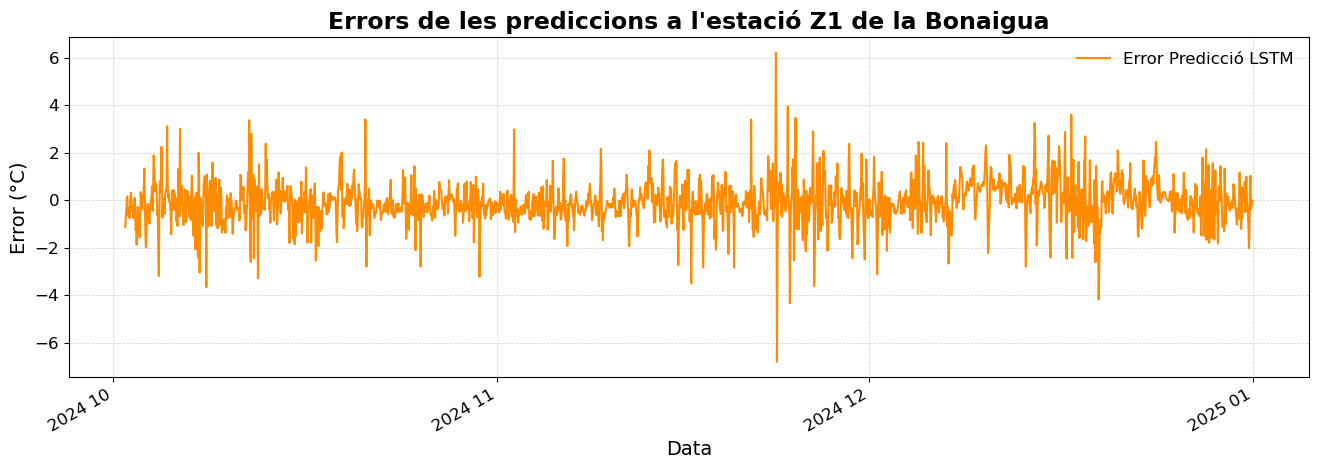

In [71]:
# Grafic dels errors de les prediccions
plt.figure(figsize=(16, 5))
plt.plot(df_test_pred['data'], df_test_pred['error_batch'], label='Error Predicci√≥ LSTM', color='darkorange', linewidth=1.5)        
plt.plot(df_test_pred['data'], df_test_pred['error_iter'], label='Error Predicci√≥ Iterativa', color='purple', linewidth=1.5)
plt.plot(df_test_pred['data'], df_test_pred['error_reinject'], label='Error Predicci√≥ Reinjecci√≥', color='green', linewidth=1.5)

plt.title('Errors de les prediccions a l\'estaci√≥ Z1 de la Bonaigua', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Error (¬∞C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()   


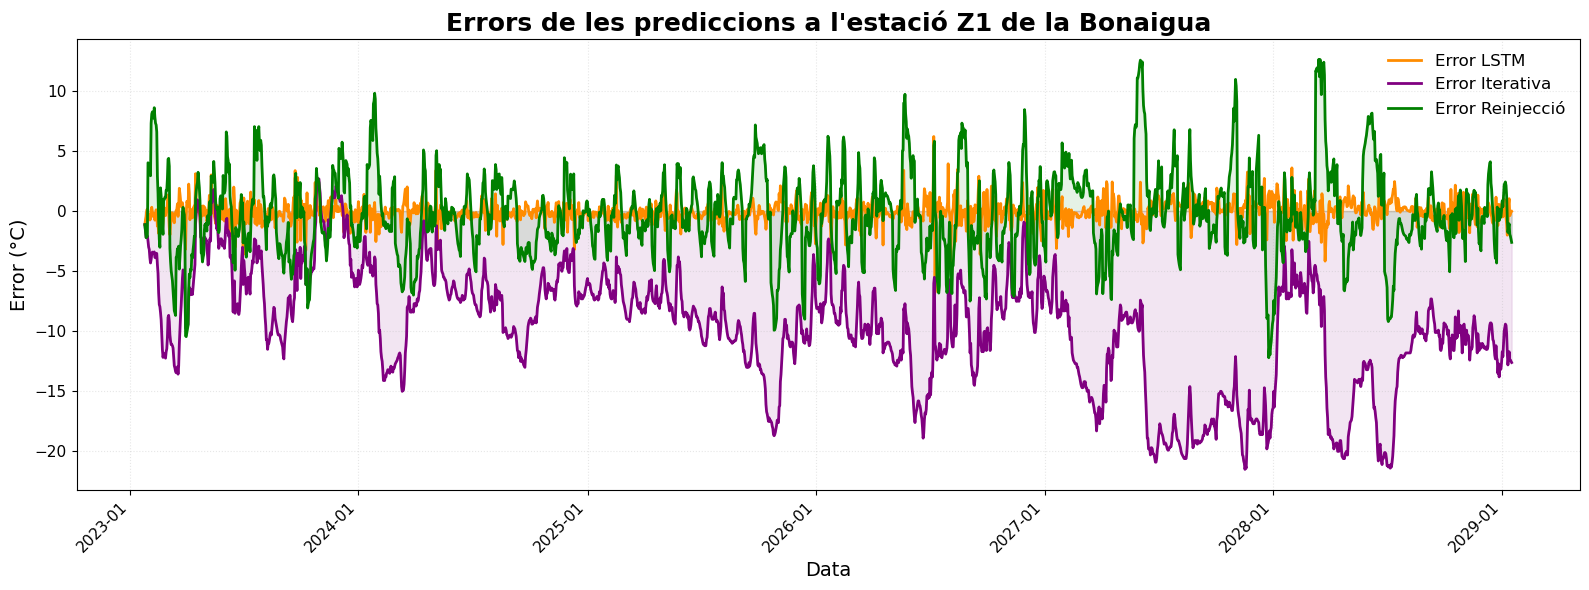

In [83]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ens assegurem que 'data' √©s de tipus datetime
df_test_pred['data'] = pd.to_datetime(df_test_pred['data'])

plt.figure(figsize=(16, 6))

# Plot de cada l√≠nia amb √†rea sota
for col, color, label in zip(
    ['error_batch', 'error_iter', 'error_reinject'],
    ['darkorange', 'purple', 'green'],
    ['Error LSTM', 'Error Iterativa', 'Error Reinjecci√≥']
):
    x = df_test_pred['data']
    y = df_test_pred[col].astype(float)
    plt.plot(x, y, label=label, color=color, linewidth=2)
    plt.fill_between(x, 0, y, color=color, alpha=0.1)

# Est√®tica del gr√†fic
plt.title("Errors de les prediccions a l'estaci√≥ Z1 de la Bonaigua", fontsize=18, weight='bold')
plt.xlabel("Data", fontsize=14)
plt.ylabel("Error (¬∞C)", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle=':', alpha=0.3)
plt.legend(fontsize=12, frameon=False)

# Format de dates autom√†tic segons l'interval real del DataFrame
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate(rotation=45)

plt.tight_layout()
plt.show()


# Model Multioutput LSTM

## Preparaci√≥ de les seq√º√®ncies per a l'entrenament

In [111]:
# Parametres Globals del model LSTM

# Parametritzaci√≥ per a la creaci√≥ de seq√º√®ncies multi-step 
WINDOW_SIZE = 24  # provar m√©s tard 48, 72, 168...
N_OUTPUTS = 5  # Nombre de passos de predicci√≥ futura (multi-step)
N_SLIDE = N_OUTPUTS  # Despla√ßament de la finestra, 1 per predicci√≥ simple
N_FEATURES = 1  # Nom√©s una variable: temperatura

In [112]:
# Creem una copia de df_test per aquest model multi-step
df_test_pred_multi = df_test.copy()


# Creem les sequences per LSTM d'entrada i sortida tant per train com per test
# X_train, X_val i X_test seran les dades d'entrada, i y_train, y_val i y_test seran les etiquetes (valors a predir)

X_train, y_train = create_sequences(df_train['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_val, y_val = create_sequences(df_val['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_test, y_test = create_sequences(df_test_pred_multi['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)

In [129]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(7881, 24, 1) (7881, 5)
(436, 24, 1) (436, 5)
(436, 24, 1) (436, 5)


## Definici√≥ del Model Multioutput i entrenament

In [115]:
# ============================
# Definim el model LSTM multi-output
# ============================


model_multi = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, N_FEATURES)),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(N_OUTPUTS)  # Capa final amb tantes neurones com outputs vulguem
])

model_multi.compile(
    optimizer='adam',
    loss='mse'
)

# Callback per early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [116]:
# Entrenament del model

# Reproductibilitat
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Entrenament del model
history_multi = model_multi.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1,
    shuffle=False
)


print(model_multi.summary())

Epoch 1/50
247/247 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 18ms/step - loss: 0.0351 - val_loss: 0.0063
Epoch 2/50
247/247 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 18ms/step - loss: 0.0089 - val_loss: 0.0062
Epoch 3/50
247/247 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 16ms/step - loss: 0.0073 - val_loss: 0.0056
Epoch 4/50
247/247 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 16ms/step - loss: 0.0060 - val_loss: 0.0038
Epoch 5/50
247/247 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 16ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 6/50
247/247 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 17ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 7/50
247/247 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 17ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 8/50
247/247 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 19ms/step - loss: 0.0032 - v

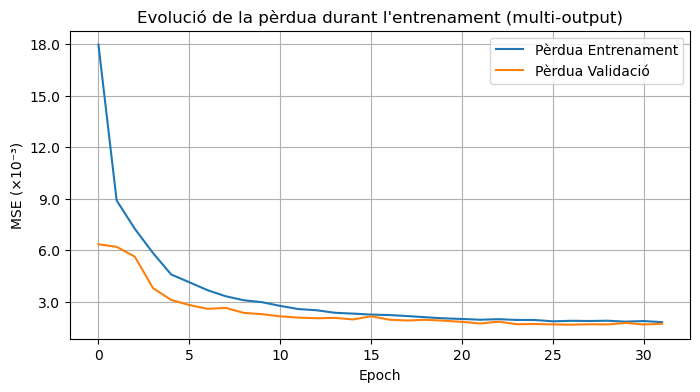

In [121]:
# ============================
# Gr√†fic de la p√®rdua durant l'entrenament
# ============================

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history_multi.history['loss'], label='P√®rdua Entrenament')
ax.plot(history_multi.history['val_loss'], label='P√®rdua Validaci√≥')
ax.set_title("Evoluci√≥ de la p√®rdua durant l'entrenament (multi-output)")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE (√ó10‚Åª¬≥)")
ax.set_xticks(np.arange(0, len(history_multi.history['loss']), 5))
ax.yaxis.set_major_formatter(FuncFormatter(escala_mil))
ax.yaxis.set_major_locator(MaxNLocator(integer=False, nbins=6))
ax.legend()
ax.grid(True)
plt.show()


In [122]:

# ============================
# Guardem i carreguem el model entrenat
# ============================

# Ruta per guardar el model multi-output
model_multi_path = os.path.join(__path__, 'models', 'lstm_model_multioutput.h5')
os.makedirs(os.path.dirname(model_multi_path), exist_ok=True)

# Guardem el model (sense optimitzador ni funci√≥ de p√®rdua)
model_multi.save(model_multi_path, include_optimizer=False)


In [ ]:
# Carreguem el model
model_multi = load_model(model_multi_path)
print("Model carregat correctament des de:", model_multi_path)
print(model_multi.summary())


## Prediccions del model Multioutput

### Predicci√≥ batch multioutput

In [153]:
# Funci√≥ per fer prediccions multi-step

def prediccio_batch_multi(model, X_test, df_test, scaler, window_size, n_outputs, nom_columna='pred_batch_multi'):

    """
    Fa prediccions multi-output de manera cont√≠nua i enganxa totes les prediccions al DataFrame original.

    Sup√≤sits:
    - S'utilitzen seq√º√®ncies creades amb `n_slide = n_outputs`, per tant NO hi ha solapament entre finestres.
    - Cada finestra prediu exactament els seg√ºents `n_outputs` valors, i la seg√ºent finestra continua on acaba l‚Äôanterior.

    Args:
        model: Model LSTM multi-output entrenat.
        X_test (np.array): Matriu d‚Äôentrada per a test (n_samples, window_size, 1).
        df_test (pd.DataFrame): DataFrame original amb les dades reals, cont√© almenys la columna 'valor'.
        scaler: MinMaxScaler utilitzat per escalar i desescalar les dades.
        window_size (int): Mida de la finestra d‚Äôentrada per a cada seq√º√®ncia.
        n_outputs (int): Nombre de passos que prediu el model (outputs per finestra).
        nom_columna (str): Nom de la columna on es guardaran les prediccions desescalades.

    Retorna:
        df_test amb la nova columna `nom_columna` que cont√© les prediccions (amb NaNs on no es pot predir).
    """
    # 1. Fer la predicci√≥ batch
    y_pred = model.predict(X_test, verbose=0)

    # 2. Desescalar les prediccions (per tornar a ¬∞C)
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    # 3. Inicialitzem la nova columna amb NaNs
    df_test[nom_columna] = np.nan

    # 4. Omplim la columna amb les prediccions multi-output (una fila per cada pas predit)
    for i in range(len(y_pred_rescaled)):
        for j in range(n_outputs):
            idx = window_size + i * n_outputs + j  # √≠ndex corresponent a la predicci√≥ j de la i-√®sima seq√º√®ncia
            if idx < len(df_test):
                df_test.at[idx, nom_columna] = y_pred_rescaled[i, j]

    return df_test



In [154]:
# Prova --> Resetejar el df_test_multi
df_test_pred_multi = df_test.copy()

df_test_pred_multi = prediccio_batch_multi(model_multi, X_test, df_test_pred_multi, scaler=scaler, window_size=WINDOW_SIZE, n_outputs=N_OUTPUTS, nom_columna='pred_batch_multi')

df_test_pred_multi

data  valor  valor_scaled  pred_batch_multi
0    2024-10-01 00:00:00+00:00   8.60          0.62               NaN
1    2024-10-01 01:00:00+00:00   9.70          0.64               NaN
2    2024-10-01 02:00:00+00:00  10.20          0.66               NaN
3    2024-10-01 03:00:00+00:00  10.50          0.66               NaN
4    2024-10-01 04:00:00+00:00  10.40          0.66               NaN
...                        ...    ...           ...               ...
2203 2024-12-31 19:00:00+00:00   0.10          0.42              2.55
2204 2024-12-31 20:00:00+00:00  -0.60          0.40               NaN
2205 2024-12-31 21:00:00+00:00  -0.60          0.40               NaN
2206 2024-12-31 22:00:00+00:00  -0.70          0.40               NaN
2207 2024-12-31 23:00:00+00:00  -0.80          0.40               NaN

[2208 rows x 4 columns]

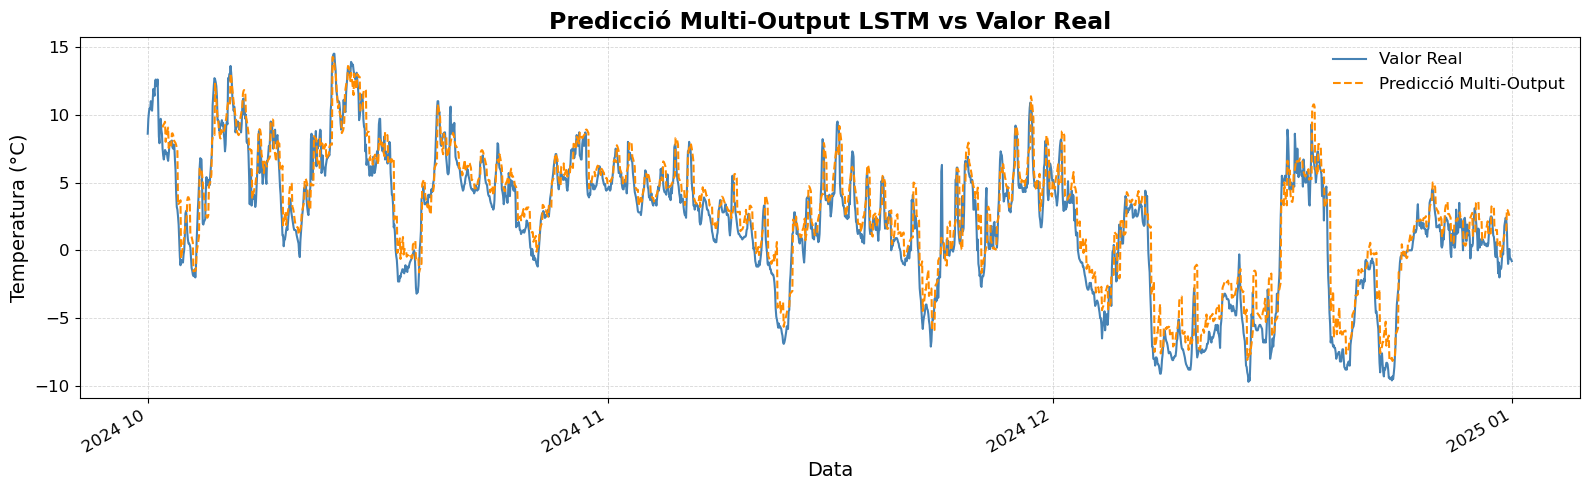

In [155]:
# Graficar les prediccions comparades amb les dades reals
plt.figure(figsize=(16, 5))
plt.plot(df_test_pred_multi['data'], df_test_pred_multi['valor'], label='Valor Real', color='steelblue', linewidth=1.5)    
plt.plot(df_test_pred_multi['data'], df_test_pred_multi['pred_batch_multi'], label='Predicci√≥ Multi-Output', color='darkorange', linewidth=1.5, linestyle='--')
plt.title('Predicci√≥ Multi-Output LSTM vs Valor Real', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (¬∞C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [157]:
df_test_pred_multi['valor'][WINDOW_SIZE:]

24      7.50
25      7.00
26      6.70
27      7.00
28      7.40
        ... 
2203    0.10
2204   -0.60
2205   -0.60
2206   -0.70
2207   -0.80
Name: valor, Length: 2184, dtype: float64

In [164]:
# Metriques de la predicci√≥ multi-output
rmse_multi = np.sqrt(mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_batch_multi'][WINDOW_SIZE:(1-N_OUTPUTS)]))
mse_multi = mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_batch_multi'][WINDOW_SIZE:(1-N_OUTPUTS)])
mae_multi = mean_absolute_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_batch_multi'][WINDOW_SIZE:(1-N_OUTPUTS)])
    

print(f"üìä M√®triques predicci√≥ multi-output: ")
print(f"   ‚ñ∏ RMSE: {rmse_multi:.4f} ¬∞C")
print(f"   ‚ñ∏ MSE: {mse_multi:.4f} ¬∞C¬≤")
print(f"   ‚ñ∏ MAE: {mae_multi:.4f} ¬∞C")

üìä M√®triques predicci√≥ multi-output: 
   ‚ñ∏ RMSE: 1.6835 ¬∞C
   ‚ñ∏ MSE: 2.8342 ¬∞C¬≤
   ‚ñ∏ MAE: 1.2866 ¬∞C


### Predicci√≥ multi-step iterativa multioutput

### Predicci√≥ amb reinjecci√≥ de dades real multioutput

## Metriques, errors i graficaci√≥ multioutput